In [3]:
from e3nn import o3
from e3nn.util.test import assert_equivariant 
import torch

In [4]:
"""Cell to determine the input irreps"""
# Compare the types of tensor products
# irrep_in = "1x4o"
# o3_type = o3.Irreps(irrep_in)
# print(f"Dimension of the input: {o3_type.dim}")

# x = torch.tensor([1.0, 0.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0])
# y = torch.tensor([0.0, 1.0, 0.0, 2.0, 1.0, 0.0, 3.0, 2.0, 1.0])

# # Full Tensor Product
# print("Full Tensor Product")
# ftp = o3.FullTensorProduct(o3_type, o3_type)
# out = ftp(x, y)
# print(f"Dimension of the output: {out.shape}")
# print(f"Output irreps: {ftp.irreps_out}")

# print("Reduced Tensor Product")
# rtp = o3.ReducedTensorProducts("ij=ji", i=irrep_in)
# out = rtp(x, y)
# print(f"Dimension of the output: {out.shape}")
# print(f"Output irreps: {rtp.irreps_out}")

'Cell to determine the input irreps'

In [5]:
# Generate a 9x9 symmetric matrix
symmetric_matrix_1 = torch.randn(9, 9)
symmetric_matrix_1 = (symmetric_matrix_1 + symmetric_matrix_1.T) / 2
symmetric_matrix_2 = torch.randn(9, 9)
symmetric_matrix_2 = (symmetric_matrix_2 + symmetric_matrix_2.T) / 2

# Create the input and output irreps
irrep_symmetric_matrix = o3.Irreps("1x0e+1x2e+1x4e+1x6e+1x8e")
irreps_out_symm_matrix = o3.Irreps("5x0e+4x1e+12x2e+10x3e+16x4e")
print(f"Irreps out of the output: {irreps_out_symm_matrix}")
print(f"Dimension of the output: {o3.Irreps(irreps_out_symm_matrix).dim}")

Irreps out of the output: 5x0e+4x1e+12x2e+10x3e+16x4e
Dimension of the output: 291


Performing fully connected tensor product


(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

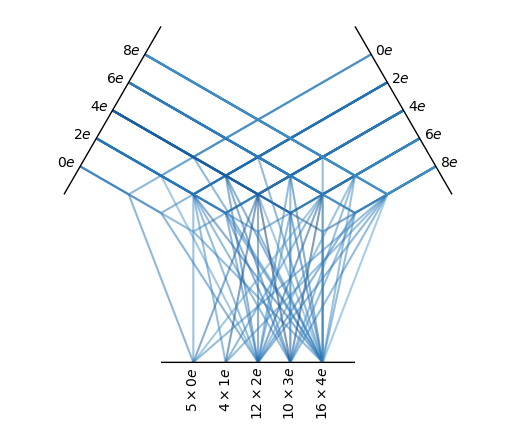

In [7]:
# print("Performing full tensor product")
# ftp_of_symm_matrices = o3.FullTensorProduct(irrep_symmetric_matrix, irrep_symmetric_matrix)
# ftp_of_symm_matrices.visualize()

print("Performing fully connected tensor product")
fctp_of_symm_matrices = o3.FullyConnectedTensorProduct(irrep_symmetric_matrix, irrep_symmetric_matrix, irreps_out_symm_matrix)
fctp_of_symm_matrices.visualize()

In [8]:
assert_equivariant(irreps_in=[irrep_symmetric_matrix, irrep_symmetric_matrix], irreps_out=irreps_out_symm_matrix, func=fctp_of_symm_matrices,)

{(0, False): tensor([1.8566e-06]), (1, False): tensor([4.3274e-06])}

In [9]:
# Generate the 45 element vector from the symmetric matrix
def generate_equi_rep_from_matrix(matrix):
    """Take out the relevant parts of the symmetric matrix to generate the 45 element vector"""
    s_comp = matrix[0:1, 0:1]
    p_comp = matrix[1:4, 1:4]
    d_comp = matrix[4:, 4:]
    sp_comp = matrix[0:1, 1:4]
    sd_comp = matrix[0:1, 4:]
    pd_comp = matrix[1:4, 4:]

    def create_voigt_notation_vector(component):
        """For a given component, create the voigt notation vector"""
        diagonal = torch.diagonal(component)
        off_diagonal = torch.triu(component, diagonal=1)
        off_diagonal = off_diagonal[off_diagonal != 0]
        return torch.cat([diagonal, off_diagonal])
    
    # Create the voigt notation vector for the s_component, p_component, d_component
    s_contrib = create_voigt_notation_vector(s_comp)
    p_contrib = create_voigt_notation_vector(p_comp)
    d_contrib = create_voigt_notation_vector(d_comp)

    # Flatten the sp, sd, pd components
    sp_contrib = sp_comp.flatten()
    sd_contrib = sd_comp.flatten()
    pd_contrib = pd_comp.flatten()

    # Concatenate the components to get the 45 element vector
    equi_rep = torch.cat([s_contrib, p_contrib, d_contrib, sp_contrib, sd_contrib, pd_contrib])

    return equi_rep

In [10]:
equi_rep_1 = generate_equi_rep_from_matrix(symmetric_matrix_1)
equi_rep_2 = generate_equi_rep_from_matrix(symmetric_matrix_2)

# Take the tensor product of the 45 element vectors
output_tp = fctp_of_symm_matrices(equi_rep_1, equi_rep_2)

In [11]:
# Test equivariance based on the data generated above
angles = o3.rand_angles()
D_g = irrep_symmetric_matrix.D_from_angles(*angles)
D_prime_g = irreps_out_symm_matrix.D_from_angles(*angles)

applied_to_inputs = fctp_of_symm_matrices(D_g @ equi_rep_1, D_g @ equi_rep_2)
applied_to_outputs = D_prime_g @ fctp_of_symm_matrices(equi_rep_1, equi_rep_2)
difference = applied_to_inputs - applied_to_outputs
print(f"Maximum absolute difference: {torch.max(torch.abs(difference))}") 

Maximum absolute difference: 1.436471939086914e-05
